In [ ]:
!pip install numpy
!pip install scipy

In [2]:
!pip install torchvision

ERROR: Could not find a version that satisfies the requirement torchvision (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3)
ERROR: No matching distribution found for torchvision
You should consider upgrading via the 'c:\users\mamiruzz\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


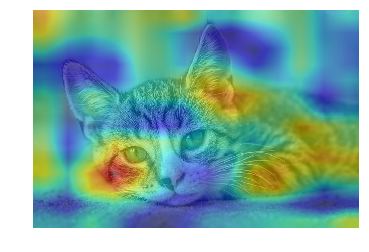

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Modify the model for Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to capture gradients
        self.target_layer.register_backward_hook(self.save_gradient)
        # Hook to capture activations
        self.target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]  # Save gradients during backward pass

    def save_activation(self, module, input, output):
        self.activations = output  # Save activations during forward pass

    def forward(self, x):
        return self.model(x)

    def backward(self, x, class_idx):
        one_hot = torch.zeros((1, self.model(x).shape[-1]), device=x.device)
        one_hot[0][class_idx] = 1
        self.model.zero_grad()
        self.model(x).backward(gradient=one_hot)

    def generate_heatmap(self):
        # Compute the heatmap using activations and gradients
        activations = self.activations.detach().cpu().numpy()[0]
        gradients = self.gradients.detach().cpu().numpy()[0]
        weights = gradients.mean(axis=(1, 2))  # Global average pooling
        heatmap = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap /= np.max(heatmap)  # Normalize
        return heatmap

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Initialize GradCAM
target_layer = model.features[28]  # Example: Layer of interest in VGG16
grad_cam = GradCAM(model, target_layer)

# Forward pass
output = grad_cam.forward(input_image)
class_idx = output.argmax(dim=1).item()

# Backward pass for target class
grad_cam.backward(input_image, class_idx)

# Generate heatmap
heatmap = grad_cam.generate_heatmap()

# Resize heatmap to match image size
heatmap = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0).float()
heatmap = torch.nn.functional.interpolate(
    heatmap, size=(image.size[1], image.size[0]), mode="bilinear", align_corners=False
).squeeze(0).squeeze(0).numpy()

# Normalize heatmap for visualization
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Overlay heatmap on the image
plt.imshow(image)
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap on the original image
plt.axis("off")
plt.show()


# DeconvNet

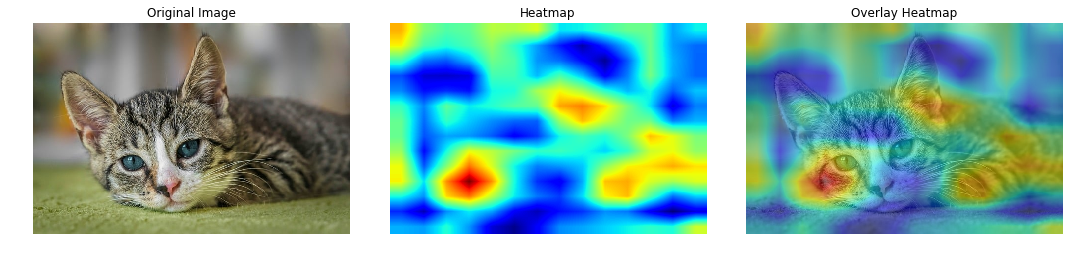

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Modify the model for Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to capture gradients
        self.target_layer.register_backward_hook(self.save_gradient)
        # Hook to capture activations
        self.target_layer.register_forward_hook(self.save_activation)

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]  # Save gradients during backward pass

    def save_activation(self, module, input, output):
        self.activations = output  # Save activations during forward pass

    def forward(self, x):
        return self.model(x)

    def backward(self, x, class_idx):
        one_hot = torch.zeros((1, self.model(x).shape[-1]), device=x.device)
        one_hot[0][class_idx] = 1
        self.model.zero_grad()
        self.model(x).backward(gradient=one_hot)

    def generate_heatmap(self):
        # Compute the heatmap using activations and gradients
        activations = self.activations.detach().cpu().numpy()[0]
        gradients = self.gradients.detach().cpu().numpy()[0]
        weights = gradients.mean(axis=(1, 2))  # Global average pooling
        heatmap = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap /= np.max(heatmap)  # Normalize
        return heatmap

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Initialize GradCAM
target_layer = model.features[28]  # Example: Layer of interest in VGG16
grad_cam = GradCAM(model, target_layer)

# Forward pass
output = grad_cam.forward(input_image)
class_idx = output.argmax(dim=1).item()

# Backward pass for target class
grad_cam.backward(input_image, class_idx)

# Generate heatmap
heatmap = grad_cam.generate_heatmap()

# Resize heatmap to match image size
heatmap = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0).float()
heatmap = torch.nn.functional.interpolate(
    heatmap, size=(image.size[1], image.size[0]), mode="bilinear", align_corners=False
).squeeze(0).squeeze(0).numpy()

# Normalize heatmap for visualization
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Visualization
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Heatmap")

# Overlay Image and Heatmap
plt.subplot(1, 3, 3)
plt.imshow(image)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Overlay Heatmap")

plt.tight_layout()
plt.show()


# LRP

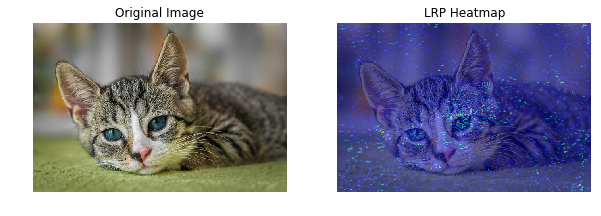

In [17]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define preprocessing for the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0), img

# LRP implementation
def lrp_vgg(model, x, target_class):
    """
    Layer-wise Relevance Propagation for VGG16.
    :param model: Pretrained VGG16 model
    :param x: Input tensor
    :param target_class: Class index for relevance computation
    :return: Relevance heatmap
    """
    # Forward pass
    x.requires_grad_()
    output = model(x)
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)

    relevance = x.grad.detach().squeeze(0).numpy()
    relevance = np.maximum(relevance, 0)  # Focus on positive relevance
    relevance = relevance.mean(axis=0)  # Average over RGB channels

    # Normalize relevance to [0, 1] for better visualization
    relevance -= relevance.min()
    relevance /= relevance.max()
    return relevance

# Visualize heatmap
def visualize_heatmap(original_img, heatmap):
    # Resize heatmap to match the original image size
    heatmap_resized = np.array(Image.fromarray((heatmap * 255).astype(np.uint8)).resize(original_img.size, Image.BILINEAR))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)  # Overlay heatmap
    plt.axis("off")
    plt.title("LRP Heatmap")
    plt.show()

# Main code
if __name__ == "__main__":
    # Load pretrained VGG16 model
    model = models.vgg16(pretrained=True)
    model.eval()

    # Load and preprocess image
    image_path = "european-shorthair-8601492_640.jpg"  # Replace with the path to your image
    input_tensor, original_img = preprocess_image(image_path)

    # Classify the image and get the predicted class
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    # Perform LRP
    heatmap = lrp_vgg(model, input_tensor, predicted_class)

    # Visualize the heatmap overlay
    visualize_heatmap(original_img, heatmap)


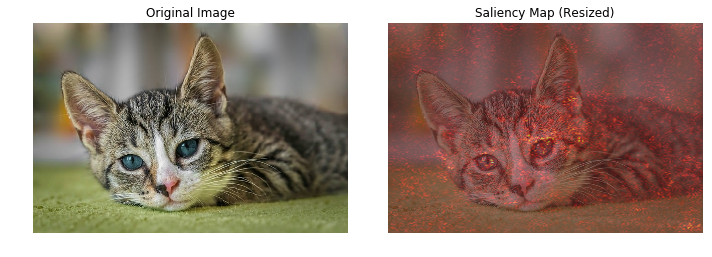

In [26]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
original_image = Image.open(image_path).convert("RGB")
input_tensor = transform(original_image).unsqueeze(0).requires_grad_()

# Forward pass
output = model(input_tensor)
class_idx = output.argmax(dim=1).item()

# Backward pass to calculate gradients
model.zero_grad()
output[0, class_idx].backward()

# Extract the gradient of the input image
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().numpy()

# Normalize for visualization
saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

# Resize the saliency map to match the original image size
saliency_resized = np.array(Image.fromarray(saliency).resize(original_image.size, Image.LANCZOS))

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(original_image, alpha=0.8)  # Overlay saliency map on the original image
plt.imshow(saliency_resized, cmap="hot", alpha=0.5)  # Overlay saliency map
plt.axis("off")
plt.title("Saliency Map (Resized)")

plt.tight_layout()
plt.show()


In [27]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
original_image = Image.open(image_path).convert("RGB")
input_tensor = transform(original_image).unsqueeze(0).requires_grad_()

# Integrated Gradients function
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a given input image and target class.
    :param model: Pretrained model.
    :param input_tensor: Input tensor for the image.
    :param target_class: Target class index.
    :param baseline: Baseline input tensor. If None, uses a tensor of zeros.
    :param steps: Number of steps for interpolation.
    :return: Integrated gradients tensor.
    """
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Generate interpolated inputs between baseline and the input image
    interpolated_inputs = [
        baseline + (step / steps) * (input_tensor - baseline)
        for step in range(steps + 1)
    ]
    interpolated_inputs = torch.cat(interpolated_inputs, dim=0).requires_grad_()
    
    # Forward pass
    outputs = model(interpolated_inputs)
    target_scores = outputs[:, target_class]
    
    # Compute gradients for each interpolated input
    gradients = []
    for score in target_scores:
        model.zero_grad()
        score.backward(retain_graph=True)
        gradients.append(interpolated_inputs.grad.clone())
    gradients = torch.stack(gradients)
    
    # Average the gradients and compute integrated gradients
    avg_gradients = gradients.mean(dim=0)
    integrated_grads = (input_tensor - baseline) * avg_gradients
    
    return integrated_grads

# Forward pass to get the target class
output = model(input_tensor)
class_idx = output.argmax(dim=1).item()

# Compute Integrated Gradients
integrated_grads = integrated_gradients(model, input_tensor, class_idx)
integrated_grads = torch.max(integrated_grads.abs(), dim=1)[0].squeeze().cpu().numpy()

# Normalize Integrated Gradients for visualization
integrated_grads = (integrated_grads - np.min(integrated_grads)) / (
    np.max(integrated_grads) - np.min(integrated_grads)
)

# Resize Integrated Gradients to match original image size
integrated_grads_resized = np.array(
    Image.fromarray(integrated_grads).resize(original_image.size, Image.LANCZOS)
)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(original_image, alpha=0.8)  # Overlay Integrated Gradients on the original image
plt.imshow(integrated_grads_resized, cmap="hot", alpha=0.5)  # Overlay Integrated Gradients
plt.axis("off")
plt.title("Integrated Gradients")

plt.tight_layout()
plt.show()


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!1


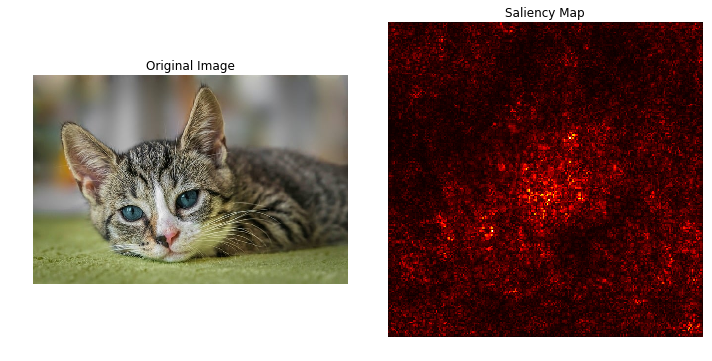

In [22]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
original_image = Image.open(image_path).convert("RGB")
input_tensor = transform(original_image).unsqueeze(0).requires_grad_()

# Forward pass
output = model(input_tensor)
class_idx = output.argmax(dim=1).item()

# Backward pass to calculate gradients
model.zero_grad()
output[0, class_idx].backward()

# Extract the gradient of the input image
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
saliency = saliency.squeeze().cpu().numpy()

# Normalize for visualization
saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.axis("off")
plt.title("Saliency Map")

plt.tight_layout()
plt.show()


In [24]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
original_image = Image.open(image_path).convert("RGB")
input_tensor = transform(original_image).unsqueeze(0).requires_grad_()

# Forward pass to get the target class
output = model(input_tensor)
class_idx = output.argmax(dim=1).item()

# SmoothGrad function
def smooth_grad(model, input_tensor, target_class, num_samples=50, noise_level=0.1):
    """
    Compute SmoothGrad for a given input image and target class.
    :param model: Pretrained model.
    :param input_tensor: Input tensor for the image.
    :param target_class: Target class index.
    :param num_samples: Number of perturbed samples to generate.
    :param noise_level: Standard deviation of Gaussian noise.
    :return: Smoothed gradients.
    """
    smooth_grad = torch.zeros_like(input_tensor)
    
    for _ in range(num_samples):
        noise = noise_level * torch.randn_like(input_tensor)  # Add Gaussian noise
        noisy_input = input_tensor + noise
        noisy_input.requires_grad_()
        
        output = model(noisy_input)
        target = output[0, target_class]
        
        model.zero_grad()
        target.backward()
        smooth_grad += noisy_input.grad.data.abs()
    
    return smooth_grad / num_samples

# Compute SmoothGrad
smooth_grad_result = smooth_grad(model, input_tensor, class_idx)
smooth_grad_result = smooth_grad_result.squeeze().cpu().numpy()

# Normalize SmoothGrad for visualization
smooth_grad_result = (smooth_grad_result - np.min(smooth_grad_result)) / (
    np.max(smooth_grad_result) - np.min(smooth_grad_result)
)

# Visualization
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")

# SmoothGrad Result
plt.subplot(1, 2, 2)
plt.imshow(smooth_grad_result[0], cmap="hot")  # Show the first channel as heatmap
plt.axis("off")
plt.title("SmoothGrad")

plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'data'

# Lime

In [21]:
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image

# Prediction function
def predict(images):
    """
    Predict function for LIME.
    :param images: List of images (numpy arrays) to predict.
    :return: Softmax probabilities for each image.
    """
    processed_images = torch.stack([transform(Image.fromarray(img)) for img in images]).to("cpu")
    with torch.no_grad():
        outputs = model(processed_images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probabilities

# Path to the input image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
input_tensor, original_image = preprocess_image(image_path)

# Load LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for a specific class
explanation = explainer.explain_instance(
    np.array(original_image), 
    predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
)

# Visualize explanation for the top predicted class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    top_label, positive_only=True, num_features=10, hide_rest=False
)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.axis("off")
plt.title("Original Image")

# LIME Explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.title("LIME Explanation")

plt.tight_layout()
plt.show()


ImportError: cannot import name '_validate_lengths'

In [8]:
!pip install lime

In [ ]:
!pip install torch torchvision pillow matplotlib scikit-image
!pip install scikit-learn==0.23.2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load the pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Function for LIME: Converts the tensor back to numpy array
def predict_fn(images):
    """Prediction function for LIME. Converts numpy images to model inputs."""
    images = [transforms.ToTensor()(Image.fromarray(img).resize((224, 224))).numpy() for img in images]
    inputs = torch.tensor(images, dtype=torch.float32)
    outputs = model(inputs)
    probabilities = torch.nn.functional.softmax(outputs, dim=1).detach().numpy()
    return probabilities

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(image),  # Input image as a numpy array
    predict_fn,       # Prediction function
    top_labels=5,     # Number of top labels to explain
    hide_color=0,     # Background color to replace
    num_samples=1000  # Number of perturbed samples
)

# Visualize the explanation for the top predicted class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation (Label: {top_label})")
plt.axis("off")

plt.tight_layout()
plt.show()


ImportError: cannot import name '_validate_lengths'

In [12]:
import shap
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# SHAP explanation
explainer = shap.DeepExplainer(model, input_image)
shap_values = explainer.shap_values(input_image)

# Visualize SHAP values for the top class
shap.image_plot([shap_values[0]], [input_image.squeeze().permute(1, 2, 0).numpy()])


ModuleNotFoundError: No module named 'numba.core'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Define the prediction function for LIME
def predict_fn(images):
    """
    Prediction function for LIME. Converts numpy images to model inputs.
    """
    transformed_images = []
    for img in images:
        img_pil = Image.fromarray(img.astype('uint8')).resize((224, 224))
        img_tensor = transform(img_pil).numpy()
        transformed_images.append(img_tensor)
    inputs = torch.tensor(np.array(transformed_images), dtype=torch.float32)
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
    return probabilities

# Create a LIME explainer instance
explainer = lime_image.LimeImageExplainer()

# Explain the model's predictions for the image
explanation = explainer.explain_instance(
    np.array(image),  # Input image as a numpy array
    predict_fn,       # Prediction function
    top_labels=5,     # Number of top labels to explain
    hide_color=0,     # Background color for perturbation
    num_samples=1000  # Number of perturbation samples
)

# Visualize the explanation for the top predicted class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot the original image and the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Label: {top_label})")
plt.axis("off")

plt.tight_layout()
plt.show()


ImportError: cannot import name '_validate_lengths'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Load a pretrained model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocessing function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "european-shorthair-8601492_640.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Define the prediction function for LIME
def predict_fn(images):
    transformed_images = []
    for img in images:
        img_pil = Image.fromarray(img.astype('uint8')).resize((224, 224))
        img_tensor = transform(img_pil).numpy()
        transformed_images.append(img_tensor)
    inputs = torch.tensor(np.array(transformed_images), dtype=torch.float32)
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
    return probabilities

# Create a LIME explainer instance
explainer = lime_image.LimeImageExplainer()

# Explain the model's predictions for the image
explanation = explainer.explain_instance(
    np.array(image),  # Input image as a numpy array
    predict_fn,       # Prediction function
    top_labels=5,     # Number of top labels to explain
    hide_color=0,     # Background color for perturbation
    num_samples=1000  # Number of perturbation samples
)

# Visualize the explanation for the top predicted class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot the original image and the LIME explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation (Label: {top_label})")
plt.axis("off")

plt.tight_layout()
plt.show()


ImportError: cannot import name '_validate_lengths'

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network for illustration
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Layer-wise Relevance Propagation (LRP) function
def lrp(model, x, relevance_score):
    """
    Performs Layer-wise Relevance Propagation (LRP).
    
    :param model: PyTorch model
    :param x: Input tensor
    :param relevance_score: Relevance score from the output layer
    :return: Relevance scores for each layer
    """
    layers = list(model.children())
    relevances = [relevance_score]

    # Propagate relevance backward through layers
    for layer in reversed(layers):
        z = layer(x).detach() + 1e-9  # Forward pass (adding stability term)
        s = (relevances[-1] / z).detach()  # Relevance scores per neuron
        c = (x * s).detach()  # Contribution of each neuron
        relevances.append(c.sum(dim=1, keepdim=True))  # Summed relevance per input
        x = x.detach()  # Update input for next backward pass
    
    relevances.reverse()  # Reverse to match input-to-output flow
    return relevances

# Example usage
if __name__ == "__main__":
    # Initialize model and input
    model = SimpleNN()
    x = torch.rand((1, 4))  # Random input
    output = model(x)  # Forward pass

    # Initial relevance score (equal to output for LRP-0)
    relevance_score = output.detach()

    # Compute LRP
    relevances = lrp(model, x, relevance_score)

    # Print relevance scores for each layer
    for i, rel in enumerate(relevances):
        print(f"Relevance at layer {i}: {rel}")


RuntimeError: size mismatch, m1: [1 x 4], m2: [10 x 1] at ..\aten\src\TH/generic/THTensorMath.cpp:961

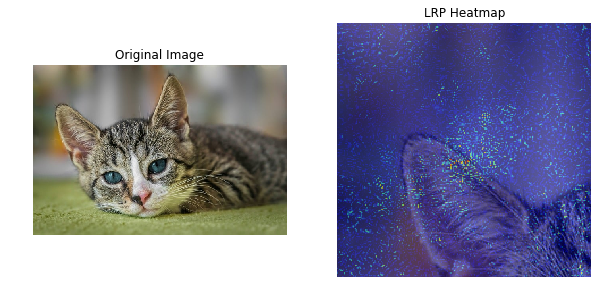

In [16]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define preprocessing for the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0), img

# LRP implementation
def lrp_vgg(model, x, target_class):
    """
    Layer-wise Relevance Propagation for VGG16.
    :param model: Pretrained VGG16 model
    :param x: Input tensor
    :param target_class: Class index for relevance computation
    :return: Relevance heatmap
    """
    # Forward pass
    x.requires_grad_()
    output = model(x)
    one_hot = torch.zeros_like(output)
    one_hot[0, target_class] = 1
    output.backward(gradient=one_hot)

    relevance = x.grad.detach().squeeze(0).numpy()
    relevance = np.maximum(relevance, 0)  # Focus on positive relevance
    relevance = relevance.mean(axis=0)  # Average over RGB channels

    return relevance

# Visualize heatmap
def visualize_heatmap(original_img, heatmap):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap
    plt.axis("off")
    plt.title("LRP Heatmap")
    plt.show()

# Main code
if __name__ == "__main__":
    # Load pretrained VGG16 model
    model = models.vgg16(pretrained=True)
    model.eval()

    # Load and preprocess image
    image_path = "european-shorthair-8601492_640.jpg"  # Replace with the path to your image
    input_tensor, original_img = preprocess_image(image_path)

    # Classify the image and get the predicted class
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

    # Perform LRP
    heatmap = lrp_vgg(model, input_tensor, predicted_class)

    # Normalize and visualize the heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize
    visualize_heatmap(original_img, heatmap)
